In [ ]:
#used the idea of Least squares nonconforming fem for formulating the loss function 
# in convection domainted problems but could not generalize in normal case 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
torch.set_default_dtype(torch.float64)

In [5]:
def a_x(x):
    return 10**(-4)
def b_x(x):
    return 1
def c_x(x):
    return 1
def f_x(x):
    return 1

In [6]:
class Model1(nn.Module):
    def __init__(self,input,output,h1):
        super().__init__()
        self.fc1=nn.Linear(input,h1)
        self.fc2=nn.Linear(h1,h1)
        self.fc4=nn.Linear(h1,h1)
        self.fc5=nn.Linear(h1,h1)
        self.fc6=nn.Linear(h1,h1)
        self.fc3=nn.Linear(h1,output)
    def forward(self,x):
        x=(x-0.1)/0.1
        x=torch.tanh(self.fc1(x))
        x=torch.tanh(self.fc2(x))
        x=torch.tanh(self.fc4(x))
        x=torch.tanh(self.fc5(x))
        x=torch.tanh(self.fc6(x))
        x=self.fc3(x)
        return x

In [7]:
class Model2(nn.Module):
    def __init__(self,input,output,h1):
        super().__init__()
        self.fc1=nn.Linear(input,h1)
        self.fc2=nn.Linear(h1,h1)
        self.fc4=nn.Linear(h1,h1)
        self.fc5=nn.Linear(h1,h1)
        self.fc6=nn.Linear(h1,h1)
        self.fc3=nn.Linear(h1,output)
    def forward(self,x):
        x=(x-0.1)/(0.99-0.1)
        x=torch.tanh(self.fc1(x))
        x=torch.tanh(self.fc2(x))
        x=torch.tanh(self.fc4(x))
        x=torch.tanh(self.fc5(x))
        x=torch.tanh(self.fc6(x))
        x=self.fc3(x)
        return x

In [8]:
b = np.random.normal(0,1, size=(1,2))
b=torch.tensor(b)

In [9]:
class Model3(nn.Module):
    def __init__(self,input,output,h1):
        super().__init__()
        self.fc1=nn.Linear(input,h1)
        self.fc2=nn.Linear(h1,h1)
        self.fc3=nn.Linear(h1,output)
        self.act=nn.SiLU()
    def forward(self,x):
        x=torch.exp(self.fc1(x))
        x=torch.exp(self.fc2(x))
        x=self.fc3(x)
        return x

In [10]:
x1=torch.linspace(0,0.1,100).reshape(-1,1).requires_grad_(True)
fx1=f_x(x1)
ax1=a_x(x1)
bx1=b_x(x1)
cx1=c_x(x1)

In [11]:
x2= torch.linspace(0.1,0.99,500).reshape(-1,1).requires_grad_(True)
fx2=f_x(x2)
ax2=a_x(x2)
bx2=b_x(x2)
cx2=c_x(x2)

In [12]:
x3= torch.linspace(0.99,1.0,400).reshape(-1,1).requires_grad_(True)
x3=(x3-0.99)/(1.0-0.99)
b = np.random.normal(0,1, size=(1,2))
b=torch.tensor(b)
sin_features = torch.sin(2 * np.pi * x3 * b)
cos_features = torch.cos(2 * np.pi * x3 * b)
x3 = torch.cat([sin_features, cos_features], axis=1)
x3 = x3.detach().requires_grad_()
x3.shape
fx3=f_x(x3)
ax3=a_x(x3)
bx3=b_x(x3)
cx3=c_x(x3)



In [13]:
x_1=torch.tensor([1.0]).reshape(-1,1).requires_grad_(True)
x_1=(x_1-0.99)/(1.0-0.99)
sin_features = torch.sin(2 * np.pi * x_1 * b)
cos_features = torch.cos(2 * np.pi * x_1 * b)
x_1 = torch.cat([sin_features, cos_features], axis=1)
x_1=x_1.detach().requires_grad_(True)


In [14]:
x_99=torch.tensor([0.99]).reshape(-1,1).requires_grad_(True)
x_99=(x_99-0.99)/(1.0-0.99)
sin_features = torch.sin(2 * np.pi * x_99 * b)
cos_features = torch.cos(2 * np.pi * x_99 * b)
x_99 = torch.cat([sin_features, cos_features], axis=1)
x_99=x_99.detach().requires_grad_(True)


In [15]:
torch.manual_seed(14)
model1=Model1(1,1,40)
model2=Model2(1,1,40)
model3=Model3(4,1,40)
optimizer = torch.optim.Adam(
    list(model1.parameters()) + list(model2.parameters()) + list(model3.parameters()),
    lr=1e-4
)


In [16]:
epochs=5000
loss_history=[]
for i in range(epochs):
    optimizer.zero_grad()
    #model 1
    ypred1=model1(x1)
    dy_dx1 = torch.autograd.grad(ypred1, x1, torch.ones_like(ypred1), create_graph=True, retain_graph=True)[0]
    a_dy_dx1=ax1*dy_dx1
    a_d2y_dx2_1 =torch.autograd.grad(a_dy_dx1, x1, torch.ones_like(a_dy_dx1), create_graph=True, retain_graph=True)[0]
    F1=-a_d2y_dx2_1+bx1*dy_dx1+cx1*ypred1-fx1
    loss1=1*torch.mean((F1-0)**2)
    y1_01=model1(0.1*torch.ones(1,1))
    y1_00=model1(0*torch.ones(1,1))
    x_01 = torch.tensor([[0.1]], requires_grad=True)
    y_01 = model1(x_01)
    dy_dx_01 = torch.autograd.grad(y_01, x_01, torch.ones_like(y_01), create_graph=True, retain_graph=True)[0]
    y1_01_dash=dy_dx_01
    #model 2
    ypred2=model2(x2)
    dy_dx2 = torch.autograd.grad(ypred2, x2, torch.ones_like(ypred2), create_graph=True, retain_graph=True)[0]
    a_dy_dx2=ax2*dy_dx2
    a_d2y_dx2_2 =torch.autograd.grad(a_dy_dx2, x2, torch.ones_like(a_dy_dx2), create_graph=True, retain_graph=True)[0]
    F2=-a_d2y_dx2_2+bx2*dy_dx2+cx2*ypred2-fx2
    loss2=1*torch.mean((F2-0)**2)
    y2_01=model2(0.1*torch.ones(1,1))
    y2_09=model2(0.99*torch.ones(1,1))
    y_01 = model2(x_01)
    dy_dx_01 = torch.autograd.grad(y_01, x_01, torch.ones_like(y_01), create_graph=True, retain_graph=True)[0]
    y2_01_dash=dy_dx_01
    x_09 =  torch.tensor([[0.99]], requires_grad=True)
    y_09 = model2(x_09)
    dy_dx_09 = torch.autograd.grad(y_09, x_09, torch.ones_like(y_09), create_graph=True, retain_graph=True)[0]
    y2_09_dash=dy_dx_09
    #model 3
    ypred3=model3(x3)
    dy_dx3 = torch.autograd.grad(ypred3, x3, torch.ones_like(ypred3), create_graph=True, retain_graph=True)[0]
    a_dy_dx3=ax3*dy_dx3
    a_d2y_dx2_3 =torch.autograd.grad(a_dy_dx3, x3, torch.ones_like(a_dy_dx3), create_graph=True, retain_graph=True)[0]
    F3=-a_d2y_dx2_3+bx3*dy_dx3+cx3*ypred3-fx3
    loss3=1*torch.mean((F3-0)**2)
    y3_1=model3(x_1)
    y3_09=model3(x_99)
    
    y_09 = model3(x_99)
    dy_dx_09 = torch.autograd.grad(y_09, x_99, torch.ones_like(y_09), create_graph=True, retain_graph=True)[0]
    y3_09_dash=dy_dx_09
    #boundary losses
    loss_0=100*torch.mean((y1_00)**2)
    loss_1=100*torch.mean((y3_1)**2)
    #interface losses
    loss_01=100*torch.mean((y1_01-y2_01)**2)
    loss_09=100*torch.mean((y2_09-y3_09)**2)
    #interface derivative losses
    loss_01_dash=1*torch.mean((y1_01_dash-y2_01_dash)**2)
    loss_09_dash=1*torch.mean((y2_09_dash-y3_09_dash)**2)
    loss=loss2+loss3+loss1+loss_0+loss_1+loss_01+loss_09+loss_01_dash+loss_09_dash
    loss.backward()
    optimizer.step()
    loss_history.append(loss.detach().numpy())

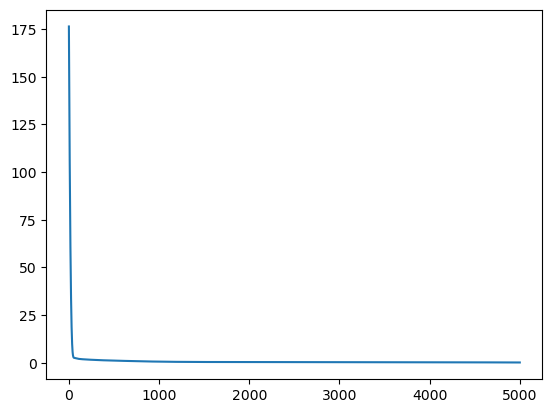

In [17]:
plt.plot(range(epochs),loss_history)

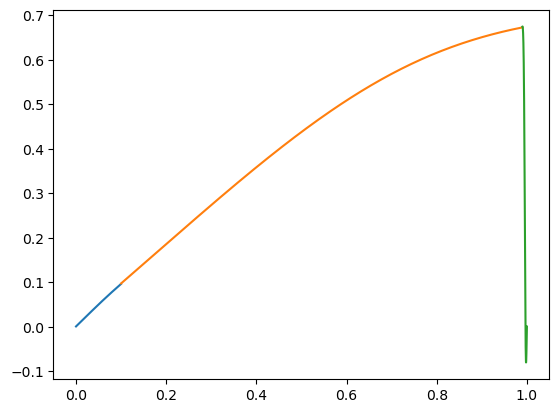

In [18]:
with torch.no_grad():
    epsilon = 10**(-4)
    e_inv = np.exp(-1)
    e_neg10001 = np.exp(-(1/epsilon+1))
    e_neg10002 = np.exp(-(1/epsilon+2))
    A = (e_inv - 1) * e_neg10001 / (1 - e_neg10002)
    B = -1 - A
    def y_stable(x):
        return ((e_inv - 1) * np.exp(-(1/epsilon+1) * (1 - x)) / (1 - e_neg10002)+ (-1 - (e_inv - 1) * e_neg10001 / (1 - e_neg10002)) * np.exp(-x) + 1)
    x1= np.linspace(0,0.1,200).reshape(-1, 1)  
    x= np.linspace(0.1,0.99,200).reshape(-1, 1)
    x2= np.linspace(0.99,1,200).reshape(-1, 1)
    #plt.plot(x1,y_stable(x1))
    #plt.plot(x,y_stable(x))
    x1= np.linspace(0,0.1,200).reshape(-1, 1)  
    x= np.linspace(0.1,0.99,200).reshape(-1, 1)
    x2= np.linspace(0.99,1,200).reshape(-1, 1)

    x1=torch.DoubleTensor(x1)
    x=torch.DoubleTensor(x)
    x2=torch.DoubleTensor(x2)
    x22=(x2-0.99)/(1.0-0.99)
    x21=torch.DoubleTensor(x22)
    sin_features = torch.sin(2 * np.pi * x21 * b)
    cos_features = torch.cos(2 * np.pi * x21 * b)
    x21 = torch.cat([sin_features, cos_features], axis=1).requires_grad_() 
    x21=x21.detach().requires_grad_(True) 
    ypred1=model1.forward(x1)
    plt.plot(x1,ypred1)
    ypred=model2.forward(x)
    plt.plot(x,ypred)
    ypred2=model3.forward(x21)
    plt.plot(x2,ypred2)